# FIRE Simulation Data Preprocessing for IFU Analysis

## Overview
This notebook processes mock IFU (Integral Field Unit) spectroscopic observations from FIRE (Feedback In Realistic Environments) simulations. The primary goals are:

1. **Data Format Conversion**: Transform specific intensity data from FIRE simulations into observationally realistic flux density units
2. **Cosmological Corrections**: Apply redshift-dependent corrections for realistic high-z observations  
3. **Instrumental Effects**: Simulate ALMA-like beam convolution and spatial resolution effects
4. **Scientific Products**: Generate moment maps and velocity spectra for analysis

## Key Scientific Context
- **FIRE Simulations**: State-of-the-art cosmological zoom-in simulations with detailed stellar feedback
- **IFU Spectroscopy**: 3D spectroscopic observations providing spatial and spectral information simultaneously
- **[CII] 158μm Line**: Critical far-infrared cooling line for studying star formation in high-redshift galaxies
- **ALMA Observations**: Ground-based interferometric observations requiring careful PSF treatment

---

## Importing Necessary Libraries

In [ ]:
# Core numerical and data manipulation libraries
import numpy as np                    # Numerical operations and array handling
import matplotlib.pyplot as plt       # Primary plotting and visualization
import matplotlib as mpl             # Advanced matplotlib configuration

# Astronomical data handling and coordinate systems
from astropy.cosmology import LambdaCDM  # Cosmological distance calculations


# Specialized astronomical libraries
import h5py as h5                    # HDF5 file handling for FIRE simulation data

# Local utility functions for IFU processing
import sys
import os
sys.path.append(os.path.abspath('/Users/arnablahiry/repos/3D_IFU_Denoising/src'))
from functions import *              # Custom beam handling and noise simulation tools

# Configure matplotlib for astronomical imaging conventions
plt.style.use('default')            # Reset to default plotting style

# Set image origin to lower-left (astronomical convention)
mpl.rcParams['image.origin'] = 'lower'

# Configure plotting parameters for publication-quality figures
mpl.rc('image', origin="lower")      # Ensure consistent image orientation
mpl.rc('grid', linestyle='-', linewidth=0.5, color='gray', alpha=0.8)  # Grid styling

# Loading Raw Mock IFU Cube Data from FIRE Simulations

## Data Source and Format
The FIRE simulation outputs provide mock observational data in HDF5 format, containing:
- **Total emission** (`image_tot.hdf5`): Combined line + continuum emission
- **Continuum emission** (`image_continuum.hdf5`): Dust continuum component only  
- **Line emission**: Extracted by subtracting continuum from total

## FIRE Simulation Details
- **Resolution**: Sub-parsec spatial resolution in zoom-in regions
- **Physics**: Stellar feedback, radiative transfer, dust physics
- **Outputs**: Synthetic observations including dust attenuation and emission
- **Spectral Coverage**: Multiple emission lines with proper line profiles

# Unit Conversion: Specific Intensity to Flux Density

## Physical Background
The IFU data represents **specific intensity** $I_{CII}$ with units $\rm{erg \, s^{-1} \, cm^{-2} \, Hz^{-1} \, sr^{-1}}$

## Conversion Process: $I_\nu \rightarrow S_\nu$

### Step 1: Solid Angle Calculation
To convert specific intensity to flux density, we integrate over the solid angle subtended by each pixel:

$$S_\nu = I_\nu \times \Omega_{\rm{pixel}}$$

### Step 2: Pixel Solid Angle Geometry
The solid angle for each pixel is:
$$\Omega_{\rm{pixel}} = \theta_{\rm{pixel}} \times \phi_{\rm{pixel}}$$

where $\theta_{\rm{pixel}}$ and $\phi_{\rm{pixel}}$ are the horizontal and vertical angular sizes.

### Step 3: Angular Diameter Distance
At redshift $z$, the angular diameter distance $D_A$ relates physical size to angular size:
$$\theta_{\rm{pixel}} = \frac{\Delta x_{\rm{physical}}}{D_A}$$

### Step 4: Final Conversion
The angular resolution depends on:
- **Spatial resolution**: Known from simulation grid ($\Delta x$ in physical units)  
- **Distance**: Angular diameter distance $D_A(z)$ from cosmological model
- **Pixel geometry**: Uniform spatial resolution → uniform angular resolution

Since all pixels have identical spatial dimensions, the solid angle is uniform across the field, enabling straightforward conversion from specific intensity to flux density in **Jansky per pixel** units.

### Mathematical Summary:
$$S_\nu \, [\rm{Jy\;px^{-1}}] = I_\nu \, [\rm{erg \, s^{-1} \, cm^{-2} \, Hz^{-1} \, sr^{-1}}] \times \Omega_{\rm{pixel}} \, [\rm{sr}] \times 10^{23}$$

In [ ]:
# ===================================================================
# SPECTRAL LINE DEFINITIONS AND DATA PATHS
# ===================================================================

# Rest-frame wavelengths of major emission lines (in microns)
# These are laboratory wavelengths for key diagnostic lines
lambda_0_dict = {"Halpha": 0.65600490570068359,     # Hydrogen recombination line          
                 "Hbeta": 0.48592987656593323,      # Hydrogen recombination line
                 "CII_158mu": 157.62730407714844}   # [CII] fine structure line (primary target)

# Focus on [CII] 158μm line for this analysis
# This is the dominant cooling line in neutral/ionized interfaces
line_list = ['CII_158mu']

# ===================================================================
# FIRE SIMULATION DATA LOADING
# ===================================================================

# File paths to FIRE simulation HDF5 outputs
# These contain pre-computed synthetic observations with radiative transfer
filepath_tot = '/Users/arnablahiry/Work/data/fire_cubes/image_tot.hdf5'  # Line + continuum
filepath_con = '/Users/arnablahiry/Work/data/fire_cubes/image_continuum.hdf5'  # Continuum only

# Open HDF5 files for reading
file_con = h5.File(filepath_con,'r')  # Continuum emission file
file_tot = h5.File(filepath_tot,'r')  # Total emission file

# ===================================================================
# SPECTRAL CUBE EXTRACTION AND LINE ISOLATION  
# ===================================================================

# Extract line emission by subtracting continuum from total emission
# Spatial cropping: select central region to focus on galaxy
# Spectral cropping: select relevant velocity range around line center
#image_array = file_tot['image_array'][:,:,:] - file_con['image_array'][:,:,:] #line emission seperated
#image_array = file_tot['image_array'][260:760, 270:770, 300:500] - file_con['image_array'][260:760, 270:770, 300:500] #line emission seperated

# Current extraction: 550×550 spatial pixels, 400 spectral channels
# Coordinates: [z_start:z_end, y_start:y_end, x_start:x_end]
image_array = file_tot['image_array'][235:785, 245:795,200:600] - file_con['image_array'][235:785, 245:795,200:600] #line emission seperated

# ===================================================================
# COSMOLOGICAL MODEL SETUP
# ===================================================================

# Define ΛCDM cosmology matching observations/simulations
# Values from Planck Collaboration (2018) or FIRE fiducial model
H0 = 69.7    # Hubble constant in km/s/Mpc
Om0 = 0.2821   # Matter density parameter (Ωₘ)
Ode0 = 0.7179  # Dark energy density parameter (ΩΛ)

# Initialize cosmological model for distance calculations
cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)

# ===================================================================
# REDSHIFT AND DISTANCE CALCULATIONS
# ===================================================================

# Target redshift for this mock observation
# High-z galaxies are primary ALMA [CII] targets
z = 4.526315229946241

# Extract spatial resolution from FIRE simulation metadata
# Convert from cm (simulation units) to kpc (astronomical units)
pix_spatial_size = file_tot['pix_size_x'][()] * 3.2407792896664e-22  #Kpc

# Calculate angular diameter distance at target redshift
# This is crucial for converting physical sizes to angular sizes
D_A = cosmo.angular_diameter_distance(z).to('kpc').value  # Convert to kpc

# ===================================================================
# ANGULAR RESOLUTION AND SOLID ANGLE CALCULATION
# ===================================================================

# Convert physical pixel size to angular size (radians)
# This gives the angular resolution of each simulation pixel
pix_angular_size_rad = pix_spatial_size / D_A  # angular size in radians

# Convert to arcseconds for comparison with observational data
pix_angular_size_arcsec = pix_angular_size_rad * 206264.806

# Calculate solid angle subtended by each pixel
# This is needed for specific intensity → flux density conversion
solid_angle_pixel = pix_angular_size_rad**2  # in steradians

print("Solid angle per pixel: {:.3e} sr".format(solid_angle_pixel))

# ===================================================================
# UNIT CONVERSION: SPECIFIC INTENSITY → FLUX DENSITY
# ===================================================================

# Transpose cube to standard astronomical convention (wavelength, y, x)
# FIRE outputs in (z, y, x) format, we need (λ, y, x)
spectral_cube_erg = image_array.T

# Conversion factor from erg/s/cm²/Hz to Jansky
# Factor of 10²³ converts to Jy, solid_angle_pixel integrates over pixel area
conversion_factor = 1e23 * solid_angle_pixel # From erg/s/cm²/Hz/sr to Jy

# Apply cosmological surface brightness dimming: (1+z)³ factor
# Convert to observed frame flux density in Jansky per pixel
spectral_cube_jy_px = (spectral_cube_erg/(1+z)**3)  * conversion_factor

# ===================================================================
# WAVELENGTH AND VELOCITY AXIS SETUP
# ===================================================================

# Reference wavelength for [CII] line (meters)
lambda_ref = 157.62730407714844* 1e-6

# Extract wavelength array from simulation (convert μm → m)
wavelengths_rest = np.asarray(file_tot['lambda_array'])* 1e-6

# Speed of light in km/s (for velocity calculations)
c = 2.99792458e8 * 1e-3

# Calculate observed wavelengths (redshifted)
wavelength_obvs = wavelengths_rest*(1+z)

# Calculate wavelength offset from line center
delta_wavelength = wavelengths_rest - lambda_ref

# Convert wavelength offset to line-of-sight velocity (km/s)
# Using Doppler formula: Δλ/λ = v/c
velocity_km_per_s = ((c * delta_wavelength) / (lambda_ref))[200:600]

# ===================================================================
# DATA CLEANING AND QUALITY CONTROL
# ===================================================================

# Replace negative flux values with small positive values
# Negative values are unphysical for emission and cause issues in log scaling
spectral_cube_jy_px[spectral_cube_jy_px < 0] = np.nanmin(spectral_cube_jy_px[spectral_cube_jy_px>0])  # Replace negative values with zeros

# Find location of peak emission for reference
max_voxel_index = np.argmax(spectral_cube_jy_px)  # Get flattened index
max_channel, max_y, max_x = np.unravel_index(max_voxel_index, spectral_cube_jy_px.shape)  # Convert to 3D index

Solid angle per pixel: 9.647e-15 sr


# Synthesized Beam Formation and PSF Modeling

## ALMA Interferometric Imaging
ALMA observations produce images through interferometric synthesis, resulting in a **synthesized beam** that acts as the Point Spread Function (PSF) of the instrument.

### Beam Characteristics
- **Shape**: 2D Elliptical Gaussian PSF
- **Parameters**: Major axis (bmaj), minor axis (bmin), position angle (bpa)  
- **Variation**: Beam shape varies across spectral channels due to frequency-dependent baselines
- **Averaging**: For broad analysis, often use average beam parameters

### Scientific Motivation
Real ALMA observations have finite angular resolution determined by:
1. **Array configuration**: Baseline lengths and orientations
2. **Frequency**: Higher frequency → better resolution  
3. **Weather conditions**: Atmospheric phase stability
4. **Calibration**: Phase and amplitude corrections

To create realistic mock observations, we must convolve the high-resolution FIRE data with an appropriate synthesized beam PSF.

# Beam Convolution and Surface Brightness Units

## Physical Process
Beam convolution simulates the finite resolution of interferometric observations:

$$S_{\nu, \rm{observed}}(\mathbf{r}) = S_{\nu, \rm{true}}(\mathbf{r}) \otimes B(\mathbf{r})$$

where $B(\mathbf{r})$ is the 2D Gaussian beam PSF and $\otimes$ denotes convolution.

## Unit Transformation: Jy/pixel → Jy/beam
After beam convolution, the natural units become **Jy/beam** rather than Jy/pixel because:

1. **Flux conservation**: Total flux is preserved during convolution
2. **Spatial spreading**: Flux redistributed over beam-sized regions  
3. **Surface brightness**: Each "resolution element" now corresponds to one beam area

This conversion is essential for:
- **Comparison with observations**: ALMA data products use Jy/beam units
- **Photometric measurements**: Aperture corrections relative to beam size
- **Noise characterization**: Thermal noise properties scale with beam area

## Implementation Details
- **Average beam**: Use representative beam size for all spectral channels
- **2D Gaussian kernel**: Appropriate for interferometric synthesized beams  
- **FFT convolution**: Efficient implementation preserving flux normalization

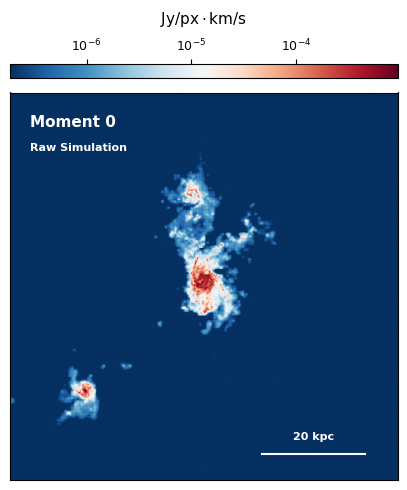

In [ ]:
# ===================================================================
# SPATIAL SCALE AND RESOLUTION SETUP
# ===================================================================

# Extract physical pixel scale from FIRE simulation
# This defines the intrinsic resolution before beam convolution
pix_spatial_scale = file_tot['pix_size_x'][()] * 3.2407792896664e-22

# Physical scale for scalebar and reference (kpc)
kpc = 20  # Scalebar length for visualization

# Spectral channel spacing for velocity integration
# Calculate from velocity array for moment map calculations
cdelt = velocity_km_per_s[1]-velocity_km_per_s[0]

# ===================================================================
# VISUALIZATION LIBRARY IMPORTS
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ===================================================================
# IMAGE DISPLAY SETUP AND PARAMETERS  
# ===================================================================

# Get spatial dimensions of spectral cube for plotting
ny, nx = spectral_cube_jy_px.shape[1], spectral_cube_jy_px.shape[2]

# Set up coordinate system for images (pixel coordinates)
x_max = nx  # Maximum x extent in pixels
y_max = ny  # Maximum y extent in pixels
extent = [0, x_max, 0, y_max]  # Image bounds: (xmin, xmax, ymin, ymax)

# Define axis tick locations for clean presentation
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]

# ===================================================================
# MOMENT 0 MAP VISUALIZATION (INTEGRATED INTENSITY)
# ===================================================================

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure with proper aspect ratio for publication
fig, ax = plt.subplots(figsize=(5, 5.5))
divider = make_axes_locatable(ax)

# Calculate moment 0 map: integrate flux over velocity
# Multiply by channel width to get proper velocity-integrated intensity
# Apply double rotation to match astronomical convention (North up, East left)
moment0_map = np.rot90(np.rot90((spectral_cube_jy_px).sum(axis=0)*cdelt))

# Display moment 0 map with logarithmic color scaling
# SymLogNorm handles both low and high intensity regions effectively
im = ax.imshow(
    moment0_map,
    norm=mpl.colors.SymLogNorm(
        vmin=cdelt*10 ** (-5.2) / (1 + z) ** 3,    # Minimum display level
        vmax=cdelt*10 ** (-1.5) / (1 + z) ** 3,    # Maximum display level  
        linthresh=1e-16 / (1 + z) ** 3             # Linear threshold for low values
    ),
    cmap='RdBu_r'  # Red-blue colormap (astronomical standard)
)

# ===================================================================
# COLORBAR CONFIGURATION
# ===================================================================

# Create horizontal colorbar at top of plot
cax = divider.append_axes("top", size="3.5%", pad=0.15)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')

# Customize colorbar labels and formatting
cbar.set_label(r'$\rm Jy/px \cdot km/s$', rotation=0, labelpad=10, fontsize=11)
cax.xaxis.set_label_position('top')    # Position label at top
cax.xaxis.set_ticks_position('top')    # Position ticks at top
cax.tick_params(axis='x', labelsize=9)

# ===================================================================
# ANNOTATIONS AND LABELS
# ===================================================================

# Add descriptive text labels
ax.text(x_max * 0.05, y_max * 0.91, 'Moment 0', color='white', fontsize=11, weight='bold')
ax.text(x_max * 0.05, y_max * 0.85, 'Raw Simulation', color='white', fontsize=8, weight='bold')

# Note: Beam representation would be added here for real observations
#add_beam(ax, 5*(500/96), 5*(500/96), 0, xy_offset=(30, 30), color='white')

# ===================================================================
# SCALEBAR IMPLEMENTATION
# ===================================================================

# Calculate scalebar length in pixel coordinates
scalebar_length = kpc/pix_spatial_scale  # Convert physical scale to pixels

# Position scalebar in bottom-right region
x0 = x_max * 0.65  # Horizontal position
y0 = y_max * 0.067  # Vertical position

# Remove axis ticks and labels for clean presentation
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Draw physical scale reference
ax.plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=1.5)
ax.text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='white', ha='center', va='bottom', fontsize=8, weight='bold')

# ===================================================================
# SAVE AND DISPLAY
# ===================================================================

plt.savefig('/Users/arnablahiry/repos/3D_IFU_Denoising/figures/moment0_raw_sim.pdf', bbox_inches='tight')
plt.show()

146.2837033278956


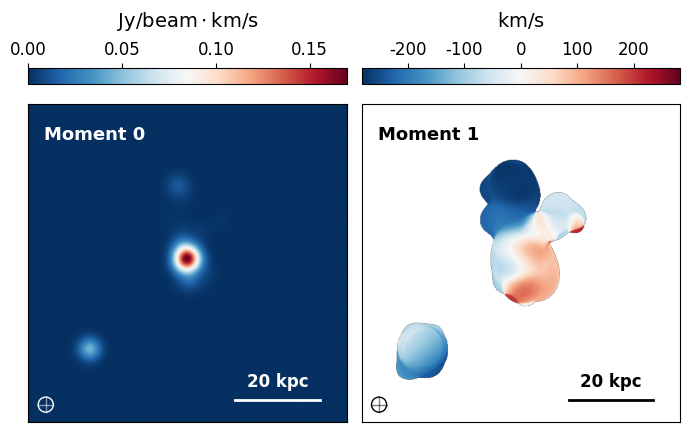

In [ ]:
# ===================================================================
# STRUCTURE DETECTION LIBRARY IMPORT  
# ===================================================================

from astrodendro import Dendrogram

# ===================================================================
# BEAM CONVOLUTION - REALISTIC ALMA PSF APPLICATION
# ===================================================================

# Apply beam convolution to simulate ALMA angular resolution
# Beam size: 5 * (550/96) pixels ≈ representative ALMA beam at [CII] frequency
# This transforms high-resolution FIRE data → realistic observational resolution
clean_cube_beam = convolve_beam(spectral_cube_jy_px, 5*(550/96))

# Extract physical pixel scale for coordinate transformations
pix_spatial_scale = file_tot['pix_size_x'][()] * 3.2407792896664e-22

# Physical scale reference for scalebars (kpc)
kpc = 20

# ===================================================================
# DENDROGRAM ANALYSIS - STRUCTURE IDENTIFICATION
# ===================================================================

# Initialize mask for significant emission regions
mask = np.zeros(clean_cube_beam.shape, dtype=bool)

# Compute dendrogram structure tree for source identification
# This identifies 3D connected emission regions above noise threshold
d1 = Dendrogram.compute(
    clean_cube_beam, 
    min_value=0.15 * clean_cube_beam.std(),    # Minimum intensity threshold (1.5σ)
    min_delta=0.15*clean_cube_beam.std(),      # Minimum significance for structure
    verbose=False                              # Suppress detailed output
)

# Create composite mask from all significant trunk structures
# This defines regions where moment analysis should be performed
for trunk in d1.trunk:
    mask |= trunk.get_mask()  # Logical OR to combine all detected structures

# ===================================================================
# VISUALIZATION SETUP FOR DUAL-PANEL MOMENT MAPS
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get image dimensions for consistent display
ny, nx = clean_cube_beam.shape[1], clean_cube_beam.shape[2]
x_max = nx  # Maximum x coordinate
y_max = ny  # Maximum y coordinate  
extent = [0, x_max, 0, y_max]  # Image extent for imshow

# Define clean tick locations
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]

# ===================================================================
# DUAL MOMENT MAP FIGURE CREATION
# ===================================================================

# Create side-by-side moment map comparison
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# ===================================================================
# MOMENT 0 MAP (LEFT PANEL) - INTEGRATED INTENSITY
# ===================================================================

# Calculate velocity-integrated intensity map
# Sum over spectral axis and multiply by velocity channel width
moment0_convolved = np.rot90(np.rot90(clean_cube_beam.sum(axis=0)*cdelt))

# Display moment 0 with appropriate color scaling
im0 = ax[0].imshow(moment0_convolved, cmap='RdBu_r', origin='lower', extent=extent)

# Configure colorbar for moment 0
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', format='%.2f')
cb0.set_label(r'$\rm Jy /beam \cdot km /s$', rotation=0, labelpad=10, fontsize=15)
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10

# Add labels and beam representation
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], 5*(500/96), 5*(500/96), 0, xy_offset=(30, 30), color='white')

# ===================================================================
# MOMENT 1 MAP (RIGHT PANEL) - VELOCITY FIELD 
# ===================================================================

# Calculate intensity-weighted velocity field (moment 1)
# Create velocity cube: multiply each channel by its velocity
moment_cube = clean_cube_beam * velocity_km_per_s[:,np.newaxis, np.newaxis]  # Broadcast velocity to spatial dimensions

# Compute flux-weighted mean velocity in detected regions only
numerator = (mask * moment_cube).sum(axis=0)      # Sum of velocity-weighted flux
denominator = (mask * clean_cube_beam).sum(axis=0)  # Sum of flux
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)

# Determine symmetric color scale for velocity field
max_velocity = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])

# Display moment 1 with symmetric red-blue color scale
im1 = ax[1].imshow(np.rot90(np.rot90(ratio)), cmap='RdBu_r', origin='lower', 
                   extent=extent, vmin=-max_velocity, vmax=max_velocity)

# Configure colorbar for moment 1
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', format='%.0f')
cb1.set_label(r'$\rm km/s$', rotation=0, labelpad=10, fontsize=15)
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10

# Add labels and beam representation (dark for visibility on velocity map)
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], 5*(500/96), 5*(500/96), 0, xy_offset=(30, 30), color='black')

# ===================================================================
# AXIS FORMATTING AND SCALEBARS
# ===================================================================

# Remove coordinate ticks for clean presentation
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# ===================================================================
# PHYSICAL SCALE REFERENCES
# ===================================================================

# Calculate scalebar dimensions  
scalebar_length = kpc/pix_spatial_scale  # Convert physical scale to pixels
print(scalebar_length)  # Display scalebar length for verification

# Position scalebars consistently
x0 = x_max * 0.65  # Horizontal position
y0 = y_max * 0.07  # Vertical position

# Scalebar for Moment 0 (white on dark background)
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1 (black for visibility on velocity field)
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')

# Ensure proper aspect ratio for astronomical images
for a in ax:
    a.set_aspect('equal')  # Square pixels for accurate morphology representation

# ===================================================================
# FINAL LAYOUT AND OUTPUT
# ===================================================================

plt.tight_layout()
plt.savefig('/Users/arnablahiry/repos/3D_IFU_Denoising/figures/moment_maps_sim.pdf', bbox_inches='tight')
plt.show()

# Beam-Convolved Analysis and Scientific Products

## Analysis Pipeline Overview
Now we proceed to create realistic ALMA-like data products by:

1. **Beam Convolution**: Apply 2D Gaussian PSF to simulate finite angular resolution
2. **Source Detection**: Use dendrogram analysis to identify coherent emission structures  
3. **Moment Analysis**: Create moment 0 (integrated intensity) and moment 1 (velocity field) maps
4. **Spectral Analysis**: Extract velocity spectra and line profiles

## Dendrogram Segmentation
We use `astrodendro` to identify significant emission regions based on:
- **Intensity threshold**: Minimum flux level for detection
- **Connectivity**: 3D connected structure requirements
- **Significance**: Signal-to-noise based filtering

This approach mimics observational source identification procedures used in real ALMA data analysis.

---

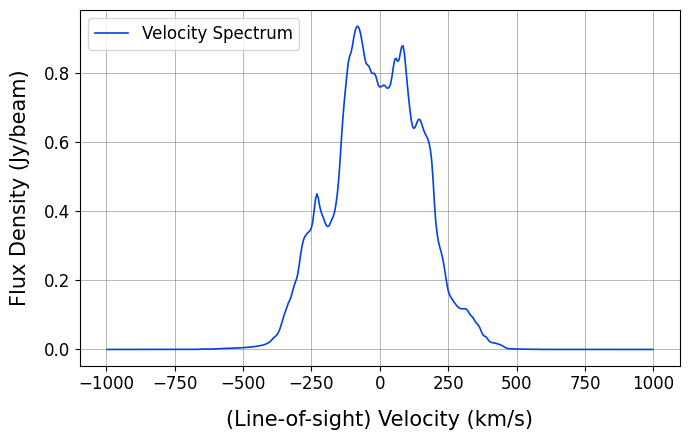

In [ ]:
# ===================================================================
# VELOCITY SPECTRUM GENERATION AND ANALYSIS
# ===================================================================

# Create publication-quality figure for velocity spectrum
plt.figure(figsize = (7, 4.5))

# Optional: Apply Gaussian smoothing for cleaner presentation
# Commented out to show raw simulation results
#plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=0.8, alpha=0.3)
from scipy.ndimage import gaussian_filter1d

# Calculate total flux spectrum by spatial integration
# Sum over both spatial dimensions to get flux vs. velocity
y_smooth = np.sum(clean_cube_beam, axis=(1,2))

# Plot velocity spectrum with clear styling
plt.plot(velocity_km_per_s, y_smooth, color='xkcd:blue', 
         label='Velocity Spectrum', linewidth=1.2)

# ===================================================================
# AXIS LABELS AND FORMATTING
# ===================================================================

# Configure axis labels with proper units and formatting
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)

# Set tick label sizes for readability
plt.tick_params(axis='x', labelsize=12)  # X-axis tick labels
plt.tick_params(axis='y', labelsize=12)  # Y-axis tick labels

# ===================================================================
# VISUAL ENHANCEMENTS
# ===================================================================

# Add grid for easier reading of values
plt.grid(True)

# Add legend to identify the data
plt.legend(fontsize = 12, loc='upper left')

# Optimize layout to prevent label cutoff
plt.tight_layout()

# ===================================================================
# OUTPUT AND DISPLAY
# ===================================================================

# Save high-quality PDF for publication
plt.savefig('/Users/arnablahiry/repos/3D_IFU_Denoising/figures/init_velocity_spectrum_sim.pdf', bbox_inches='tight')

# Display the plot
plt.show()

# Velocity Spectrum Analysis

## Scientific Context
The **velocity spectrum** (or line profile) represents the total flux as a function of line-of-sight velocity. This 1D projection of the 3D spectral cube provides crucial information about:

### Kinematic Properties
- **Line width**: Measures velocity dispersion and turbulence
- **Peak velocity**: Indicates systemic velocity of the galaxy
- **Line asymmetry**: May reveal outflows, inflows, or complex kinematics
- **Multiple components**: Can identify distinct kinematic structures

### Observational Comparison
The velocity spectrum enables direct comparison with:
- **ALMA line profiles**: Single-dish or integrated interferometric spectra
- **Theoretical predictions**: Galaxy formation models and feedback prescriptions  
- **Multi-wavelength data**: Comparison with optical/UV line measurements

### Analysis Applications
- **Flux measurements**: Total line luminosity determination
- **Kinematics**: Velocity dispersion and rotation curve analysis
- **ISM physics**: Turbulence and feedback signatures
- **Cosmology**: High-redshift galaxy evolution studies

---